In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from lightgbm import LGBMClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
app_test = pd.read_csv("/content/drive/My Drive/FDS/application_test.csv")
app_train = pd.read_csv("/content/drive/My Drive/FDS/application_train.csv")

In [6]:
bureau=pd.read_csv("//content/drive/My Drive/FDS/bureau.csv")
samp_sub=pd.read_csv("/content/drive/My Drive/FDS/sample_submission.csv")
br_bal=pd.read_csv("/content/drive/My Drive/FDS/bureau_balance.csv")
ccb=pd.read_csv("/content/drive/My Drive/FDS/credit_card_balance.csv")
prev_appl=pd.read_csv("/content/drive/My Drive/FDS/previous_application.csv")
pos=pd.read_csv("/content/drive/My Drive/FDS/POS_CASH_balance.csv")
inp=pd.read_csv("/content/drive/My Drive/FDS/installments_payments.csv")

In [7]:
# Examine the missing values.
# Please note, we will just check the information on the missing values. 
# We will not remove any column as of now because we don't know which column is going to be important in future.
# Function to detect missing values.
def missing_info(dataframe):
    count=dataframe.isnull().sum()
  # standardised score of the missing values:
    mean_null=sum(count)/len(dataframe.columns)
    var_null=sum(((count-mean_null)**2))/len(dataframe.columns)
  # Make a table with the results
    metric=((count-mean_null)/var_null)*1000000
    result=pd.concat([count,metric],axis=1)
    result.columns=["count","standardised_score"]
    result=result[result.iloc[:,1] != 0].sort_values(
          'count', ascending=False).round(1)
    return(result.head())

In [8]:
missing_info(app_train)

,count,standardised_score
COMMONAREA_MEDI,214865,18.4
COMMONAREA_AVG,214865,18.4
COMMONAREA_MODE,214865,18.4
NONLIVINGAPARTMENTS_MODE,213514,18.2
NONLIVINGAPARTMENTS_AVG,213514,18.2


In [9]:
# The first hurdle we face is due to the columns with several categories. So, first we have to encode those columns to proceed further.
# Before that, let's have a look at the column types of the data sets.

#################### Function to check the column types #######################
def coltyp(dataframe):
    type=dataframe.dtypes.value_counts()
  #we will see number of unique categories for each object
    cat= dataframe.select_dtypes('object').apply(pd.Series.nunique,axis=0)
    print(type)
    return cat

In [8]:
coltyp(app_train)

float64    65
int64      41
object     16
dtype: int64


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [10]:
feat_train = pd.DataFrame()
feat_train['employment_to_birth_ratio'] = app_train['DAYS_EMPLOYED'] /app_train['DAYS_BIRTH']

feat_train['credit_to_annuity_ratio'] = app_train['AMT_CREDIT'] / app_train['AMT_ANNUITY']

feat_train['credit_to_goods_ratio'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']

feat_train['credit_to_income_ratio'] = app_train['AMT_CREDIT'] /  app_train['AMT_INCOME_TOTAL']

app_train=pd.concat([app_train,feat_train],axis=1)

In [11]:
feat_test = pd.DataFrame()
feat_test['employment_to_birth_ratio'] = app_test['DAYS_EMPLOYED'] /app_test['DAYS_BIRTH']

feat_test['credit_to_annuity_ratio'] = app_test['AMT_CREDIT'] / app_test['AMT_ANNUITY']

feat_test['credit_to_goods_ratio'] = app_test['AMT_CREDIT'] / app_test['AMT_GOODS_PRICE']

feat_test['credit_to_income_ratio'] = app_test['AMT_CREDIT'] /  app_test['AMT_INCOME_TOTAL']

app_test=pd.concat([app_test,feat_test],axis=1)

In [12]:
# Now we have to conduct the one hot encoding:

from sklearn.preprocessing import LabelEncoder as le
def onehot(dataframe):
    df=pd.get_dummies(dataframe)
    print(df.shape)
    return(df)

In [13]:
app_train=onehot(app_train)

(307511, 250)


In [14]:
app_test = onehot(app_test)

(48744, 246)


In [15]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(app_train)
app_train.loc[:]=imputer.transform(app_train)

In [16]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(app_test)
app_test.loc[:]=imputer.transform(app_test)

In [17]:
app_train_target = app_train['TARGET']
app_train, app_test = app_train.align(app_test,join='inner',axis=1)
print('Training dataset shape: ', app_train.shape)
print('Testing dataset shape: ',app_test.shape)
app_train['TARGET'] = app_train_target

Training dataset shape:  (307511, 246)
Testing dataset shape:  (48744, 246)


#Working with bureau_balance and bureau dataset

In [17]:
br_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Counting the values of all the status:\
C = Closed\
X = Status unknown\
0 = Current status, no delay\
1 = 1 month delay\
2 = 2 month delay\
3 = 3 month delay\
4 = 4 month delay


In [18]:
br_bal.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

Grouping the status with respect to the SK_ID_BUREAU of bureau_balance and then using unstack method to reshape the dataset formed by grouping. Some more columns are added by calculating the size, minimum and maximum value with respect to "SK_ID_BUREAU" using groupby function. Then the obtained unstack data is merged with bureau dataset.

In [19]:
bureau_counts = br_bal.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize = False)
bureau_counts_unstacked = bureau_counts.unstack('STATUS')

In [20]:
bureau_counts_unstacked.columns = ['STATUS_0', 'STATUS_1','STATUS_2','STATUS_3','STATUS_4','STATUS_5','STATUS_C','STATUS_X',]
bureau_counts_unstacked['MONTHS_COUNT'] = br_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].size()
bureau_counts_unstacked['MONTHS_MIN'] = br_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min()
bureau_counts_unstacked['MONTHS_MAX'] = br_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].max()

In [21]:
bureau = bureau.join(bureau_counts_unstacked, how='left', on='SK_ID_BUREAU')

In [19]:
bureau.shape

(1716428, 28)

In [23]:
coltyp(bureau)

float64    19
int64       6
object      3
dtype: int64


CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [22]:
bureau=onehot(bureau)

(1716428, 48)


Further bureau dataset has been grouped by "SK_ID_CURR" and obtained the average. We can drop the "SK_ID_BUREAU" as the unique id "SK_ID_CURR" is enough to identify the corresponding values.

In [23]:
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['bureau_count'] = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del bureau_avg['SK_ID_BUREAU']

#Working with previous_application

In [22]:
prev_appl.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Featuring using One-Hot-Encoding and applying groupby function to count and finding average

In [24]:
prev_appl = onehot(prev_appl)

(1670214, 164)


In [25]:
prev_appl_avg = prev_appl.groupby('SK_ID_CURR').mean()
prev_appl_count = prev_appl[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev_appl_avg['nb_app'] = prev_appl_count['SK_ID_PREV']
del prev_appl_avg['SK_ID_PREV']

#Working with POS_CASH_Balance

In [29]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [30]:
pos.NAME_CONTRACT_STATUS.value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [26]:
le = LabelEncoder()
pos['NAME_CONTRACT_STATUS'] = le.fit_transform(pos['NAME_CONTRACT_STATUS'].astype(str))
pos['UNIQUE_STATUS_COUNT'] = pos[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()['NAME_CONTRACT_STATUS']
pos['UNIQUE_STATUS_MAX'] = pos[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()['NAME_CONTRACT_STATUS']
pos.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

#Working with credit_card_balance

In [32]:
ccb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [27]:
ccb['NAME_CONTRACT_STATUS'] = le.fit_transform(ccb['NAME_CONTRACT_STATUS'].astype(str))
ccb['UNIQUE_STATUS_COUNT'] = ccb[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby("SK_ID_CURR").nunique()["NAME_CONTRACT_STATUS"]
ccb['UNIQUE_STATUS2_MAX'] = ccb[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
ccb.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

#Working with installments_payments

In [35]:
inp.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [28]:
inp_avg = inp.groupby('SK_ID_CURR').mean()
inp_max = inp.groupby('SK_ID_CURR').max()
inp_min = inp.groupby('SK_ID_CURR').min()
del inp_avg['SK_ID_PREV']

In [29]:
app_train = app_train.merge(right=prev_appl_avg.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=prev_appl_avg.reset_index(), how='left', on='SK_ID_CURR')

In [30]:
app_train = app_train.merge(right = bureau_avg.reset_index(), how="left", on="SK_ID_CURR")
app_test = app_test.merge(right = bureau_avg.reset_index(), how = "left", on="SK_ID_CURR")

In [31]:
app_train = app_train.merge(pos.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(pos.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

In [32]:
app_train = app_train.merge(ccb.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(ccb.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')


In [33]:
app_train = app_train.merge(right=inp_avg.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=inp_avg.reset_index(), how='left', on='SK_ID_CURR')

In [34]:
app_train = app_train.merge(right=inp_max.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=inp_max.reset_index(), how='left', on='SK_ID_CURR')


In [35]:
app_train = app_train.merge(right=inp_min.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=inp_min.reset_index(), how='left', on='SK_ID_CURR')

In [36]:
del prev_appl_avg, bureau_avg, pos, ccb, inp_avg, inp_max, inp_min

In [37]:
del app_train["TARGET"]

In [38]:
app_train.shape

(307511, 505)

In [39]:
app_test.shape

(48744, 505)

In [40]:
app_train_target.shape

(307511,)

In [44]:
from lightgbm import LGBMClassifier
#lgb = LGBMClassifier()
lgb.fit(app_train, app_train_target)
predictions = lgb.predict_proba(app_test)[:,1]
output = app_test[['SK_ID_CURR']].astype(int)
output['TARGET'] = predictions

In [43]:
output.to_csv("/content/drive/My Drive/FDS/lightgbm.csv", index=False)

In [ ]:
a = []
while(1):
    a.append(1)

0.821662162150897


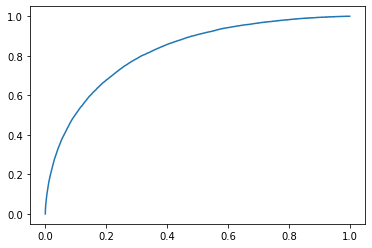

In [50]:
p=lgb.predict_proba(app_train)[:,1]
print(roc_auc_score(app_train_target,p))
fpr,tpr,thr=roc_curve(app_train_target,p)
plt.figure()
plt.plot(fpr,tpr)

In [ ]:
import os
import gc
import re
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold,KFold
import warnings
warnings.filterwarnings('ignore')

In [47]:
print('Removing features with more than 80% missing...')
test = app_test[app_test.columns[app_train.isnull().mean() < 0.85]]
data = app_train[app_train.columns[app_train.isnull().mean() < 0.85]]

Removing features with more than 80% missing...


In [48]:
#Delete customer Id
del data['SK_ID_CURR']
del test['SK_ID_CURR']

In [49]:
data.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in data.columns]

In [50]:
test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test.columns]

In [52]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(data, app_train_target, test_size=0.2, shuffle=True)

In [57]:
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

In [58]:
params = [          
          { 'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'auc'},
            'learning_rate': 0.01,
            'max_depth':8,
            'num_leaves': 35,              
            'feature_fraction':0.125681745820782, 
            'bagging_freq': 5,
            'min_split_gain':0.0970905919552776,
            'min_child_weight':9.42012323936088,
            'reg_alpha':4.82988348810309,
            'reg_lambda':4.23709841316042,
            'verbose': 1},
          { 'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'auc'},
            'learning_rate': 0.015,
            'max_depth':8,
            'num_leaves': 35,              
            'colsample_bytree':0.9497036,   
            'subsample':0.8715623,            
            'bagging_freq': 5,
            'min_split_gain':0.0222415,
            'min_child_weight':39.3259775,
            'reg_alpha':0.041545473,
            'reg_lambda':0.0735294,  
            'verbose': 1,},
    
          { 'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'auc'},
            'learning_rate': 0.02,
            'max_depth':8,
            'num_leaves': 34,              
            'feature_fraction' : 0.125681745820782,
            'bagging_fraction' : 0.967396467593587,
            'bagging_freq':5,
            'min_split_gain':0.0970905919552776,
            'min_child_weight':9.42012323936088,
            'reg_alpha':4.82988348810309,
            'reg_lambda':4.23709841316042,
            'verbose': 1,}
         ]

In [59]:
debug = False
GLOBAL = False
num_rows = 20000 if debug else None
# cache_path = "./cache/v1/"
seed = 1024
# path = "../input/"

In [61]:
folds = StratifiedKFold(n_splits= 5 , shuffle=True, random_state=seed)

oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

feats = [f for f in data.columns if f not in  ['SK_ID_CURR',"TARGET"]]

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data, app_train_target)):
    X_train, y_train = data[feats].iloc[trn_idx], app_train_target.iloc[trn_idx]
    X_test, y_test = data[feats].iloc[val_idx], app_train_target.iloc[val_idx]

    lgb_train = lgb.Dataset(X_train, y_train)
    del X_train, y_train,
    lgb_eval = lgb.Dataset(X_test,y_test,reference=lgb_train)
        
    clf = lgb.train(params[1],
                    lgb_train,
                    num_boost_round=20000,
                    valid_sets=[lgb_eval],
                    early_stopping_rounds=200,
                    verbose_eval=100)

    oof_preds[val_idx] = clf.predict(X_test, num_iteration=clf.best_iteration)
    
    sub = pd.Series(clf.predict(test[feats], num_iteration=clf.best_iteration)).rank(pct=True).values
    sub_preds +=  sub / (folds.n_splits)
        
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = clf.feature_name()
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(y_test, oof_preds[val_idx])))
    del X_test, y_test
    gc.collect()

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.755078
[200]	valid_0's auc: 0.77066
[300]	valid_0's auc: 0.777748
[400]	valid_0's auc: 0.781598
[500]	valid_0's auc: 0.78385
[600]	valid_0's auc: 0.785653
[700]	valid_0's auc: 0.786777
[800]	valid_0's auc: 0.787824
[900]	valid_0's auc: 0.788433
[1000]	valid_0's auc: 0.788825
[1100]	valid_0's auc: 0.789136
[1200]	valid_0's auc: 0.789216
[1300]	valid_0's auc: 0.789271
[1400]	valid_0's auc: 0.789392
[1500]	valid_0's auc: 0.789505
[1600]	valid_0's auc: 0.789639
[1700]	valid_0's auc: 0.789657
[1800]	valid_0's auc: 0.789546
[1900]	valid_0's auc: 0.789619
[2000]	valid_0's auc: 0.78962
Early stopping, best iteration is:
[1887]	valid_0's auc: 0.789681
Fold  1 AUC : 0.789681
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.743632
[200]	valid_0's auc: 0.760289
[300]	valid_0's auc: 0.76833
[400]	valid_0's auc: 0.772841
[500]	valid_0's auc: 0.775889
[600]	valid_0's auc: 0.77790

In [63]:
print('Full AUC score %.6f' % roc_auc_score(app_train_target, oof_preds)) 
test['TARGET'] = sub_preds

Full AUC score 0.788484


In [75]:
test[['SK_ID_CURR', 'TARGET']].to_csv('/content/drive/My Drive/FDS/submission_cross.csv', index=False)

In [74]:
test['SK_ID_CURR']=app_test ['SK_ID_CURR'].astype(int)